In [149]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
import os.path
import math
from surprise import (Reader, Dataset, NormalPredictor, BaselineOnly,
                      accuracy, SVD, SVDpp, NMF, KNNBasic, KNNWithMeans,
                      KNNWithZScore, KNNBaseline)
from surprise.model_selection import (cross_validate, KFold,
                                      train_test_split, GridSearchCV,
                                      RandomizedSearchCV)

# Always make it pretty.
plt.style.use('ggplot')
%matplotlib inline
sns.set_style(style="whitegrid")

In [150]:
# Load Data
business_df = pd.read_csv('../datasets/comunidades/business_community_1.csv')
review_df = pd.read_csv('../datasets/comunidades/review_community_1.csv')
user_df = pd.read_csv('../datasets/comunidades/user_community_1.csv')


In [151]:
# Drop unneeded columns for users
user_df.drop(columns=['useful', 'funny', 'cool', 'fans', 'elite',
                      'friends', 'compliment_hot', 'compliment_more',
                      'compliment_profile', 'compliment_cute',
                      'compliment_list', 'compliment_note',
                      'compliment_plain', 'compliment_cool',
                      'compliment_funny', 'compliment_writer',
                      'compliment_photos'],
             axis=1, inplace=True)

In [152]:
# Drop unneeded columns for businesses
business_df.drop(columns=['address', 'postal_code', 'latitude', 'longitude',
                          'attributes', 'hours'],
                 axis=1, inplace=True)

In [153]:
# Drop unneeded columns for reviews
review_df.drop(columns=['useful', 'funny', 'cool'], axis=1, inplace=True)

In [154]:
# Look at the shapes of dataframes after removing columns
print(business_df.shape)
print(user_df.shape)
print(review_df.shape)

(34, 8)
(5597, 5)
(7189, 6)


In [155]:
# Rename columns to avoid mix-ups
review_df.rename(columns={'stars': 'review_stars'}, inplace=True)
business_df.rename(columns={'stars': 'business_stars',
                            'name': 'business_name'}, inplace=True)
user_df.rename(columns={'name': 'user_name'}, inplace=True)

In [156]:
# Combine review/user/business dfs, specifically for tucson restaraunts
review_business_df = review_df.merge(business_df, on='business_id')
all_df = review_business_df.merge(user_df, on='user_id')
tucson_df = (all_df[(all_df['city'] == 'Tucson') &
                    (all_df['is_open'] == 1)])
tucson_df = tucson_df[tucson_df['categories'].str.contains(
    'Restaurants', case=False, na=False)]

In [157]:
# Rename columns to avoid mix-ups
all_df.rename(columns={'review_count_x': 'business_review_count',
                       'review_count_y': 'user_review_count'},
              inplace=True)
tucson_df.rename(columns={'review_count_x': 'business_review_count',
                          'review_count_y': 'user_review_count'},
                 inplace=True)
tucson_df.reset_index(drop=True, inplace=True)

In [158]:
tucson_df.head(10)

,review_id,user_id,business_id,review_stars,text,date,business_name,city,state,business_stars,business_review_count,is_open,categories,user_name,user_review_count,yelping_since,average_stars
0,ymhbOMW63B_vGaRFR3XT0A,yZdAhQ_KmKuCZmbBy9YDQg,5Ce3lZksYVkCbrihqylVHQ,5,I just started going to Sushi Nara this month ...,2014-07-25 17:56:26,Sushi Nara,Tucson,AZ,4.5,159,1,"Sushi Bars, Japanese, Restaurants",Kathleen,3,2011-07-16 14:37:43,5.00
1,jT0mpPypQH_eFoyIHhuM6A,To1Pq4io8oCT8f6ryRdPeQ,5Ce3lZksYVkCbrihqylVHQ,5,My kitty and I love this sushi place!! We love...,2015-10-07 23:33:00,Sushi Nara,Tucson,AZ,4.5,159,1,"Sushi Bars, Japanese, Restaurants",Mike,25,2013-09-16 22:08:11,3.59
2,RkpAuBy0Oi-zqGvfh76Tuw,fGYAraOy6CFZeg8-YRyMxw,5Ce3lZksYVkCbrihqylVHQ,5,"Great bang for your buck, sushi was fresh and ...",2018-06-09 03:48:32,Sushi Nara,Tucson,AZ,4.5,159,1,"Sushi Bars, Japanese, Restaurants",Richard,4,2017-06-03 22:48:38,3.00
3,VI3-W_oNX1ROBHgUZWs2cw,pHmgeQkvhJPDGdqVw7AmtQ,5Ce3lZksYVkCbrihqylVHQ,5,Good service and nice a quit at lunch time eve...,2018-07-17 20:19:21,Sushi Nara,Tucson,AZ,4.5,159,1,"Sushi Bars, Japanese, Restaurants",Lauren,18,2017-06-29 21:39:55,4.47
4,7HtOcNgZXEmikXjB3bFfhA,Gu5NAzjgp6hwuxMHgQL0ng,5Ce3lZksYVkCbrihqylVHQ,4,A welcome addition to the growing number of ex...,2014-12-01 22:58:17,Sushi Nara,Tucson,AZ,4.5,159,1,"Sushi Bars, Japanese, Restaurants",Ed,9,2012-07-18 03:19:26,4.50
5,HVXgyuEYfpPzG9vZ-rTpGQ,LUrY9f-pEudeBwTkbw4JWw,5Ce3lZksYVkCbrihqylVHQ,3,....meh....\n\n my husband and I are big sushi...,2015-05-17 02:29:56,Sushi Nara,Tucson,AZ,4.5,159,1,"Sushi Bars, Japanese, Restaurants",Erin,13,2011-11-01 01:51:13,4.15
6,KJ1TrX11MTRsz8OhhGLdiQ,dmsz__xB7hIh2KPhUfSPBw,5Ce3lZksYVkCbrihqylVHQ,4,"Based on the exceptional reviews, my wife and ...",2015-02-07 04:31:33,Sushi Nara,Tucson,AZ,4.5,159,1,"Sushi Bars, Japanese, Restaurants",Jack,9,2012-11-09 00:07:17,3.10
7,6nyPiHlFJSR91pcQzSfHDg,cJmzXpTlAgTyTx4YFC1MKg,5Ce3lZksYVkCbrihqylVHQ,5,"Sushi Nara is awesome- always fresh, well prep...",2016-04-26 05:14:03,Sushi Nara,Tucson,AZ,4.5,159,1,"Sushi Bars, Japanese, Restaurants",K,41,2013-01-17 23:07:50,4.00
8,Nf3jZC1jYKkQS1ohnBeEuQ,fRdb00MgeCElpJule1YLhQ,5Ce3lZksYVkCbrihqylVHQ,5,"Great little sushi place, especially for a nov...",2015-09-26 03:33:45,Sushi Nara,Tucson,AZ,4.5,159,1,"Sushi Bars, Japanese, Restaurants",Nichole,18,2012-11-22 20:54:54,3.94
9,JSBIDtK_XifkMl2AMmbY6Q,Po4BCvGrKtP_OfZwMUp87g,5Ce3lZksYVkCbrihqylVHQ,4,Great sushi. Nice service. Long wait if it's a...,2017-03-17 02:56:09,Sushi Nara,Tucson,AZ,4.5,159,1,"Sushi Bars, Japanese, Restaurants",Preston,40,2015-12-07 02:28:47,2.60


In [159]:
all_df.to_csv('../datasets/comunidades/tucson_com_df.csv')
tucson_df.to_csv('../datasets/comunidades/all_df.csv')

In [160]:
# Create a utility matrix of user ids, business ids, and reviews
utility = tucson_df[['user_id', 'business_id', 'review_stars']]
utility.head()

,user_id,business_id,review_stars
0,yZdAhQ_KmKuCZmbBy9YDQg,5Ce3lZksYVkCbrihqylVHQ,5
1,To1Pq4io8oCT8f6ryRdPeQ,5Ce3lZksYVkCbrihqylVHQ,5
2,fGYAraOy6CFZeg8-YRyMxw,5Ce3lZksYVkCbrihqylVHQ,5
3,pHmgeQkvhJPDGdqVw7AmtQ,5Ce3lZksYVkCbrihqylVHQ,5
4,Gu5NAzjgp6hwuxMHgQL0ng,5Ce3lZksYVkCbrihqylVHQ,4


<AxesSubplot:>

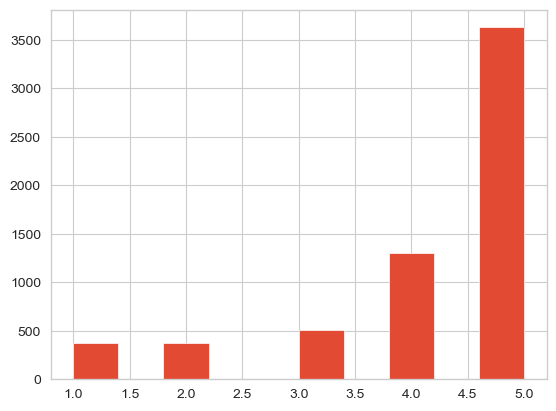

In [161]:
utility['review_stars'].hist()

In [162]:
# Prepare data to run models
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(utility, reader)
trainset, testset = train_test_split(data, test_size=0.2)

In [163]:
# Looking at the trainset in a dataframe
iterator = trainset.all_ratings()
trainset_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in iterator:
    trainset_df.loc[i] = [uid, iid, rating]
    i = i+1

trainset_df.head(2)

,uid,iid,rating
0,0.0,0.0,5.0
1,1.0,1.0,4.0


In [164]:
def inner_to_raw_iid(row):
    '''
    Returns the raw item id associated with a given Surprise inner id
    
    Parameters:
    row: corresponds to a row in a dataframe
    
    Returns:
    output (float): raw item id
    '''
    output = trainset.to_raw_iid(row['iid'])
    return output

In [165]:
def inner_to_raw_uid(row):
    '''
    Returns the raw user id associated with a given Surprise inner id
    
    Parameters:
    row: corresponds to a row in a dataframe
    
    Returns:
    output (float): raw user id
    '''
    output = trainset.to_raw_uid(row['uid'])
    return output

In [166]:
# Place testset into a dataframe
testset_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset:
    testset_df.loc[i] = [uid, iid, rating]
    i = i+1

testset_df.head(2)

,uid,iid,rating
0,xyFtRXaTjhStZB3Zb9uFvA,eaNouTpxnIu7M80xdeLxFw,5.0
1,00USBTqdUmOwBSvJ0PzXIw,SVJJIoAiW3vHwoSpVnUcLQ,2.0


In [167]:
# Convert Surprise inner ids into raw ids
trainset_df['iid'] = trainset_df.apply(inner_to_raw_iid, axis=1)
trainset_df['uid'] = trainset_df.apply(inner_to_raw_uid, axis=1)

In [168]:
trainset_df.head()

,uid,iid,rating
0,qde7cw7YIJutTmRiFTEmfg,CJoO4HYD0tZRXlZqA04wmw,5.0
1,aKQS69MIMJpT-UpxieaHRQ,nEaTbGFlU7d9eLU2kl6KBw,4.0
2,uiBi3V6n_zef4W3Y4qbudw,5CX7rtnwYnmqFCihOyWivg,4.0
3,uiBi3V6n_zef4W3Y4qbudw,KZA_HEOsBXf8dtrk9rqNJA,4.0
4,uiBi3V6n_zef4W3Y4qbudw,RHdEScVIAQ7xzFFMiQEnAQ,4.0


In [169]:
# Number of users that are in train and not test
len(np.setdiff1d(testset_df['uid'].unique(), trainset_df['uid'].unique()))

857

In [170]:
# Number of restaurants that are in train and not test
len(np.setdiff1d(testset_df['iid'].unique(), trainset_df['iid'].unique()))

0

In [171]:
# Random ratings based on distribution of the training set
normal_predictor = NormalPredictor()
normal_predictor.fit(trainset)
predictions = normal_predictor.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.1711
1.1711137380649768
MSE: 2.4035
2.403477240994979
RMSE: 1.5503
1.5503152069804964


In [172]:
# Baseline ratings
baseline_only = BaselineOnly()
baseline_only.fit(trainset)
predictions = baseline_only.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Estimating biases using als...
MAE:  0.9045
0.9045215565441793
MSE: 1.3116
1.3116203193986873
RMSE: 1.1453
1.14525993529796


In [173]:
# Funk SVD (defaults)
svd = SVD()
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.9035
0.9034802629444926
MSE: 1.3170
1.3169537697413156
RMSE: 1.1476
1.147586062019453


In [174]:
# SVD++ (defaults)
svdpp = SVDpp()
svdpp.fit(trainset)
predictions = svdpp.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.9199
0.9198696051904565
MSE: 1.3459
1.345936361961456
RMSE: 1.1601
1.1601449745447574


In [175]:
# NMF (defaults)
nmf = NMF()
nmf.fit(trainset)
predictions = nmf.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.0190
1.01898657416753
MSE: 1.6521
1.6520600072170484
RMSE: 1.2853
1.2853248644669752


In [176]:
# KNN (defaults)
knnbasic = KNNBasic()
knnbasic.fit(trainset)
predictions = knnbasic.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9532
0.953219850362894
MSE: 1.4859
1.485889662221753
RMSE: 1.2190
1.2189707388701967


In [177]:
utility['user_id'].value_counts()

EnFRwa9xPq9QaE4jBjFhlw    16
9Y1YkloHk2MAE3hkwYdFKA    16
I06gY9An4o81XpejLWD9DA    16
1viszljzsa8W7VnYPuWosw    11
0yrF14nWVAFeI0fG29a63g    10
                          ..
DK57YibC5ShBmqQl97CKog     1
-n4YtwxACJo8HFe4FingTg     1
oC6-n3vx_5Tbk7TccGNJfA     1
x2uo_JKTVK6miyMAPb1rdA     1
jjj-rTey-q2XN1oRNHpD7A     1
Name: user_id, Length: 4966, dtype: int64

In [178]:
#preds = preds.sort_values('user_id', ascending=True)

In [179]:
# Trim utility matrix to users, restaurants with at least 3 reviews
utility_3 = utility[utility['user_id'].map(utility['user_id']
                                           .value_counts()) >= 3]
utility_3 = utility_3[utility_3['business_id'].map(utility_3['business_id']
                                                   .value_counts()) >= 3]

In [180]:
utility_3.shape

(953, 3)

In [181]:
utility_3.head()

,user_id,business_id,review_stars
9,Po4BCvGrKtP_OfZwMUp87g,5Ce3lZksYVkCbrihqylVHQ,4
10,Po4BCvGrKtP_OfZwMUp87g,p7tSGmWpFV246aYhwODgBg,5
11,Po4BCvGrKtP_OfZwMUp87g,KZA_HEOsBXf8dtrk9rqNJA,5
18,lYu0e98ZSNeXIjcLpkjhhA,5Ce3lZksYVkCbrihqylVHQ,3
19,lYu0e98ZSNeXIjcLpkjhhA,RHdEScVIAQ7xzFFMiQEnAQ,5


In [182]:
# Get updated density (roughly four times higher now)
utility_users = len(utility_3['user_id'].unique())
utility_businesses = len(utility_3['business_id'].unique())
utility_reviews = utility_3.shape[0]
utility_reviews / (utility_businesses * utility_users)

0.14300720288115246

In [183]:
# Examine dimensions post-trimming
print(utility_users)
print(utility_businesses)
print(utility_reviews)

238
28
953


<AxesSubplot:>

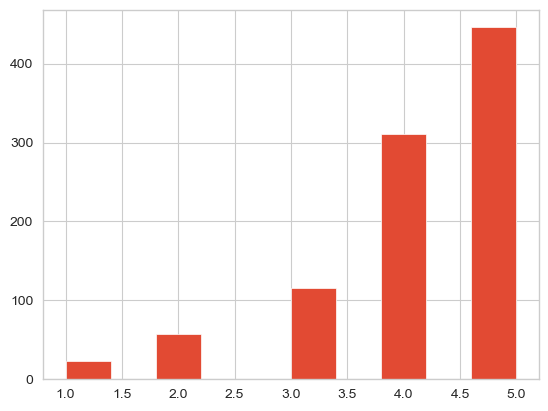

In [184]:
utility_3['review_stars'].hist()

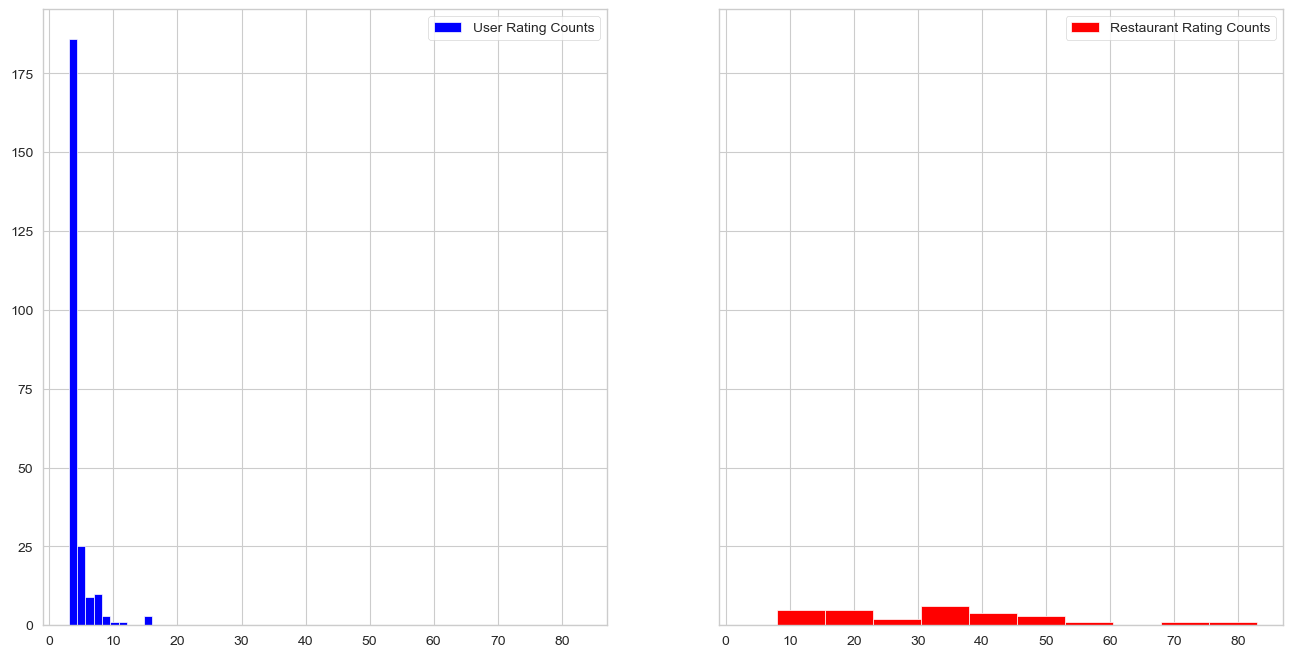

In [185]:
# Examining review distributions on the same scale
utility_user_ratings = utility_3.groupby('user_id').count()['business_id']
utility_rest_ratings = utility_3.groupby('business_id').count()['review_stars']
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True,sharex=True)
ax[0].hist(utility_user_ratings,label='User Rating Counts', color='b')
ax[1].hist(utility_rest_ratings,label='Restaurant Rating Counts', color='r')
ax[0].legend()
ax[1].legend();

In [186]:
# Max values for reviews by user and restaurant
utility_user_ratings.max(), utility_rest_ratings.max()

(16, 83)

In [187]:
# Minimum values for reviews by user and restaurant
utility_user_ratings.min(), utility_rest_ratings.min()

(3, 8)

In [188]:
# Prepare data for models with adjusted utility matrix
reader = Reader(rating_scale=(1,5))
data_3 = Dataset.load_from_df(utility_3, reader)
trainset_3, testset_3 = train_test_split(data_3, test_size=0.2)

In [189]:
def inner_to_raw_iid_3(row):
    '''
    Returns the raw item id associated with a given Surprise inner id.
    Slightly adjusted from previous function for new trainset.
    
    Parameters:
    row: corresponds to a row in a dataframe
    
    Returns:
    output (float): raw item id
    '''
    output = trainset_3.to_raw_iid(row['iid'])
    return output

def inner_to_raw_uid_3(row):
    '''
    Returns the raw user id associated with a given Surprise inner id
    Slightly adjusted from previous function for new trainset.
    
    Parameters:
    row: corresponds to a row in a dataframe
    
    Returns:
    output (float): raw user id
    '''
    output = trainset_3.to_raw_uid(row['uid'])
    return output

In [190]:
# Place trainset/testset into dataframes
iterator_3 = trainset_3.all_ratings()
trainset_3_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in iterator_3:
    trainset_3_df.loc[i] = [uid, iid, rating]
    i = i+1

testset_3_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset_3:
    testset_3_df.loc[i] = [uid, iid, rating]
    i = i+1

trainset_3_df['iid'] = trainset_3_df.apply(inner_to_raw_iid_3, axis=1)
trainset_3_df['uid'] = trainset_3_df.apply(inner_to_raw_uid_3, axis=1)

In [191]:
# Number of users that are in train and not test
len(np.setdiff1d(testset_3_df['uid'].unique(), trainset_3_df['uid'].unique()))

3

In [192]:
# Number of restaurants that are in train and not test
len(np.setdiff1d(testset_3_df['iid'].unique(), trainset_3_df['iid'].unique()))

0

In [193]:
# Random ratings based on distribution of the training set
normal_predictor = NormalPredictor()
normal_predictor.fit(trainset_3)
predictions = normal_predictor.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.0307
1.0306913414253172
MSE: 1.7741
1.7740864873106001
RMSE: 1.3319
1.331948380122368


In [194]:
# Baseline ratings
baseline_only = BaselineOnly()
baseline_only.fit(trainset_3)
predictions = baseline_only.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Estimating biases using als...
MAE:  0.7385
0.7385074845147901
MSE: 0.8982
0.8981814736659011
RMSE: 0.9477
0.9477243658711646


In [195]:
# NMF (defaults)
nmf = NMF()
nmf.fit(trainset_3)
predictions = nmf.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.8126
0.8125500656345327
MSE: 1.1062
1.1062228102498772
RMSE: 1.0518
1.0517712727821944


In [196]:
# Funk SVD (defaults)
svd = SVD()
svd.fit(trainset_3)
predictions = svd.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.7039
0.7039354458547226
MSE: 0.7934
0.7933815513782283
RMSE: 0.8907
0.8907196817058823


In [197]:
# SVD++ (defaults)
svdpp = SVDpp()
svdpp.fit(trainset_3)
predictions = svdpp.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.7160
0.7160444271354912
MSE: 0.8271
0.8271163880544826
RMSE: 0.9095
0.9094593932960848


In [198]:
# KNN (defaults)
knnbasic = KNNBasic()
knnbasic.fit(trainset_3)
predictions = knnbasic.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7514
0.7513672109748607
MSE: 0.9437
0.9437425391237639
RMSE: 0.9715
0.971464121377503


In [199]:
# KNN with means (defaults)
knnwithmeans = KNNWithMeans()
knnwithmeans.fit(trainset_3)
predictions = knnwithmeans.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7214
0.7214403769938235
MSE: 0.9824
0.9824384074066023
RMSE: 0.9912
0.991180310239566


In [200]:
# KNN with z-score (defaults)
knnwithzscore = KNNWithZScore()
knnwithzscore.fit(trainset_3)
predictions = knnwithzscore.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7221
0.7220737485416876
MSE: 0.9878
0.9878283430739098
RMSE: 0.9939
0.9938955393168387


In [201]:
# Run grid searches to find optimal SVD++ parameters
param_grid = {'n_factors': [10, 20, 50],
              'n_epochs': [20, 30, 40],
              'lr_all': [0.002, 0.007, 0.01],
              'reg_all': [0.01, 0.03, 0.05]}
gs = GridSearchCV(algo_class=SVDpp,
                  param_grid=param_grid,
                  measures = ['rmse', 'mae'],
                  cv=5,
                  n_jobs=-1)
gs.fit(data_3)

In [202]:
gs.best_score['rmse']

0.9596073022055995

In [203]:
gs.best_params['rmse']

{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.05}

In [204]:
gs.best_score['mae']

0.7513784905858273

In [205]:
gs.best_params['mae']

{'n_factors': 50, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.05}

In [206]:
param_grid2 = {'n_factors': [10, 12, 14, 16, 20],
               'n_epochs': [15, 20, 25, 30],
               'lr_all': [0.006, 0.007, 0.008],
               'reg_all': [0.04, 0.05, 0.06, 0.07]}
gs2 = GridSearchCV(algo_class=SVDpp,
                   param_grid=param_grid2,
                   measures = ['rmse', 'mae'],
                   cv=5,
                   n_jobs=-1)
gs2.fit(data_3)

In [207]:
gs2.best_params['rmse']

{'n_factors': 12, 'n_epochs': 15, 'lr_all': 0.007, 'reg_all': 0.04}

In [208]:
gs2.best_score['rmse']

0.9592257892534469

In [209]:
gs2.best_params['mae']

{'n_factors': 16, 'n_epochs': 30, 'lr_all': 0.008, 'reg_all': 0.06}

In [210]:
gs2.best_score['mae']

0.7497111097154805

In [211]:
param_grid3 = {'n_factors': [20],
               'n_epochs': [20, 25],
               'lr_all': [0.004, 0.006, 0.007, 0.009],
               'reg_all': [0.02, 0.04, 0.05, 0.06, 0.08]}
gs3 = GridSearchCV(algo_class=SVDpp,
                   param_grid=param_grid3,
                   measures = ['rmse', 'mae'],
                   cv=5,
                   n_jobs=-1)
gs3.fit(data_3)

In [212]:
gs3.best_score['rmse']

0.9486992630991382

In [213]:
gs3.best_params['rmse']

{'n_factors': 20, 'n_epochs': 25, 'lr_all': 0.007, 'reg_all': 0.02}

In [214]:
gs3.best_params['mae']

{'n_factors': 20, 'n_epochs': 25, 'lr_all': 0.009, 'reg_all': 0.06}

In [215]:
# Save utility matrix to text file in order to explore percentiles
utility_3.to_csv('../datasets/comunidades/utility.txt', sep='\t', header=False, index=False)

In [216]:
# NOT MY CODE - ADAPTED FROM MANSOURY ET AL'S "FLATTER IS BETTER"
# https://github.com/masoudmansoury/percentile/blob/master/percentile.py

class Percentile:
    def __init__(self):
        # self.fold = 1

        self.transformation_type = "user" # possible values: user and item
        self.percentile_position = "first" # possible values: first, floormedian, ceilmedian, last, and zscore
        self.percentile_smoothed = True # possible values: True and False
        self.percentile_smoothedparam = 5 # a paramter related to smoothing. It's an integer value and will be applied when self.smoothed is True
        self.input = "../datasets/filter_data/utility.txt"
        self.output = "../datasets/filter_data/percentile.txt"
        self.dictionary = {}
        self.rating_scale = []

    # creating user/item profile, it would be like <userid/itemid, [rate1, rate2, rate3, ...]>
    def create_profile(self):
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                if self.transformation_type is "user":
                    per.dictionary.setdefault(data[0].rstrip(), []).append(data[2].rstrip())
                elif self.transformation_type is "item":
                    per.dictionary.setdefault(data[1].rstrip(), []).append(data[2].rstrip())

    # percentile computation for first index
    def compute_firstindex_percentile(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # find the index of the first occurrence of repeated numbers e.g., repeated ratings
                position = values.index(float(data[2].rstrip())) + 1
                # percentile computation
                p = 0.0
                if(self.percentile_smoothed):
                    p = 100 * float(position + ((self.getRatePosition(float(data[2].rstrip())) -1 ) * self.percentile_smoothedparam)) / (len(values) + 1 + (len(self.rating_scale) * self.percentile_smoothedparam))
                else:
                    p = float(100 * position) / float(len(values) + 1)
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(p) + '\n')

        out.close()

    # percentile computation for floor median index
    def compute_floormedianindex_percentile(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # find the index of the floor median occurrence of repeated numbers e.g., repeated ratings
                last = len(values) - 1 - values[::-1].index(float(data[2].rstrip())) + 1
                first = values.index(float(data[2].rstrip())) + 1
                position = int(math.floor(float(last+first))/2)
                # percentile computation
                p = 0.0
                if(self.percentile_smoothed):
                    p = 100 * float(position + ((self.getRatePosition(float(data[2].rstrip()))-1) * self.percentile_smoothedparam) + (int(math.floor(float(self.percentile_smoothedparam/2))))) / (len(values) + 1 + (len(self.rating_scale) * self.percentile_smoothedparam))
                else:
                    p = float(100 * position) / float(len(values) + 1)
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(p) + '\n')

        out.close()

    # percentile computation for ceil median index
    def compute_ceilmedianindex_percentile(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # find the index of the ceil median occurrence of repeated numbers e.g., repeated ratings
                last = len(values) - 1 - values[::-1].index(float(data[2].rstrip())) + 2
                first = values.index(float(data[2].rstrip())) + 1
                position = int(math.ceil(float(last+first))/2)
                # percentile computation
                p = 0.0
                if(self.percentile_smoothed):
                    p = 100 * float(position + ((self.getRatePosition(float(data[2].rstrip()))-1) * self.percentile_smoothedparam) + (int(math.ceil(float(self.percentile_smoothedparam/2))))) / (len(values) + 1 + (len(self.rating_scale) * self.percentile_smoothedparam))
                else:
                    p = float(100 * position) / float(len(values) + 1)
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(p) + '\n')

        out.close()

    # percentile computation for last index
    def compute_lastindex_percentile(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # find the index of the last occurrence of repeated numbers e.g., repeated ratings
                position = len(values) - 1 - values[::-1].index(float(data[2].rstrip())) + 1
                # percentile computation
                p = 0.0
                if(self.percentile_smoothed):
                    p = 100 * float(position + (self.getRatePosition(float(data[2].rstrip())) * self.percentile_smoothedparam)) / (len(values) + 1 + (len(self.rating_scale) * self.percentile_smoothedparam))
                else:
                    p = float(100 * position) / float(len(values) + 1)
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(p) + '\n')

        out.close()

    def compute_zscore(self):
        self.delete_outputfile()
        out = open(self.output,"w")
        with open(self.input) as f:
            for line in f:
                data = line.split("\t")
                # sorting the values correspoding to the key e.g., ratings
                i = 0
                if self.transformation_type is "item":
                    i = 1
                values = sorted(map(float,list(per.dictionary.get(data[i].rstrip()))))
                # compute mean of rating profile
                mean = float(sum(values)) / max(len(values),1)
                # compute standard deviation of rating profile
                nominator = 0.0
                for j in range(len(values)):
                    nominator += math.pow(float(values[j]-mean),2)
                std = math.sqrt(nominator/float(len(values)))
                # zscore computation
                z = 0.0
                if(std != 0.0):
                    z = float(float(data[2].rstrip())-mean)/std
                out.write(data[0].rstrip() + '\t' + data[1].rstrip() + '\t' + str(z) + '\n')

        out.close()

    def transform(self):
        if(self.percentile_position is "first"):
            self.compute_firstindex_percentile()
        elif (self.percentile_position is "floormedian"):
            self.compute_floormedianindex_percentile()
        elif (self.percentile_position is "ceilmedian"):
            self.compute_ceilmedianindex_percentile()
        elif (self.percentile_position is "last"):
            self.compute_lastindex_percentile()
        elif (self.percentile_position is "zscore"):
            self.compute_zscore()

    # delete output file if exists
    def delete_outputfile(self):
        try:
            if os.path.exists(self.output):
                os.remove(self.output)
        except OSError:
            print("error")
            pass

    def getRatePosition(self, rate):
        for i in range(len(self.rating_scale)):
            if rate == self.rating_scale[i]:
                return i + 1
        return 0

    def create_ratingscale(self):
        with open(self.input) as f:
            for line in f:
                rate = line.split("\t")[2]
                if(float(rate) not in self.rating_scale):
                    self.rating_scale.append(float(rate))
        self.rating_scale.sort()

<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:86: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:112: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:135: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:154: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:156: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:158: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:160: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:162: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
<

In [217]:
# Convert utility matrix to percentile-based ratings
per = Percentile()
per.create_ratingscale()
per.create_profile()
per.transform()

In [218]:
percentile_df = pd.read_csv('../datasets/comunidades/percentile.txt',
                            sep='\t',
                            names=utility_3.columns.values)

In [219]:
percentile_df.head()

,user_id,business_id,review_stars
0,Po4BCvGrKtP_OfZwMUp87g,5Ce3lZksYVkCbrihqylVHQ,55.172414
1,Po4BCvGrKtP_OfZwMUp87g,p7tSGmWpFV246aYhwODgBg,75.862069
2,Po4BCvGrKtP_OfZwMUp87g,KZA_HEOsBXf8dtrk9rqNJA,75.862069
3,lYu0e98ZSNeXIjcLpkjhhA,5Ce3lZksYVkCbrihqylVHQ,34.375000
4,lYu0e98ZSNeXIjcLpkjhhA,RHdEScVIAQ7xzFFMiQEnAQ,71.875000


In [220]:
percentile_df['review_stars'].min(), percentile_df['review_stars'].max()

(2.380952380952381, 83.33333333333333)

<AxesSubplot:>

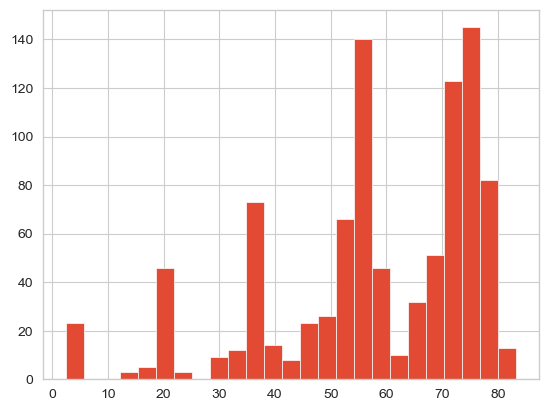

In [221]:
percentile_df['review_stars'].hist(bins=25)

In [222]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [223]:
# SVD 
svd = SVD(n_factors=20,
              n_epochs=25,
              lr_all=0.006,
              reg_all=0.08)
svdpp.fit(trainset_3)
predictions = svdpp.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.7137
0.7136654377481958
MSE: 0.8179
0.8179163145852841
RMSE: 0.9044
0.9043872591900464


In [224]:
# Place predictions into df
predictions_df = pd.DataFrame(columns=['uid', 'iid', 'true', 'predicted'])
i = 0
for uid, iid, true_r, est, _ in predictions:
    predictions_df.loc[i] = [uid, iid, true_r, est]
    i += 1

In [225]:
predictions_df.shape

(191, 4)

In [226]:
# Look at prediction distributions in relation to true ratings
predictions_df_1 = predictions_df[predictions_df['true'] == 1]
predictions_df_2 = predictions_df[predictions_df['true'] == 2]
predictions_df_3 = predictions_df[predictions_df['true'] == 3]
predictions_df_4 = predictions_df[predictions_df['true'] == 4]
predictions_df_5 = predictions_df[predictions_df['true'] == 5]

In [227]:
predictions_df_1['predicted'].mean(), predictions_df_1['predicted'].std()

(3.446168974293263, 0.5802352605899967)

In [228]:
predictions_df_2['predicted'].mean(), predictions_df_2['predicted'].std()

(3.736170094708582, 0.3952866002047123)

In [229]:
predictions_df_3['predicted'].mean(), predictions_df_3['predicted'].std()

(3.923853759046357, 0.3603478734871095)

In [230]:
predictions_df_4['predicted'].mean(), predictions_df_4['predicted'].std()

(4.136846791671505, 0.37058921350111307)

In [231]:
predictions_df_5['predicted'].mean(), predictions_df_5['predicted'].std()

(4.30125260742414, 0.3253065002398131)

<AxesSubplot:>

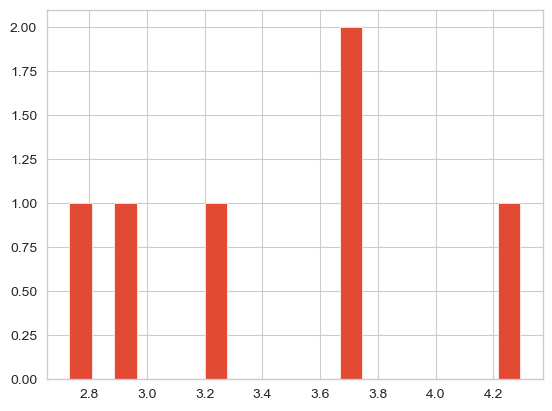

In [232]:
predictions_df_1['predicted'].hist(bins=20)

<AxesSubplot:>

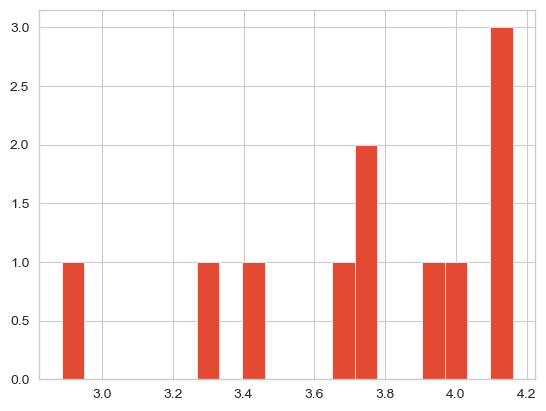

In [233]:
predictions_df_2['predicted'].hist(bins=20)

<AxesSubplot:>

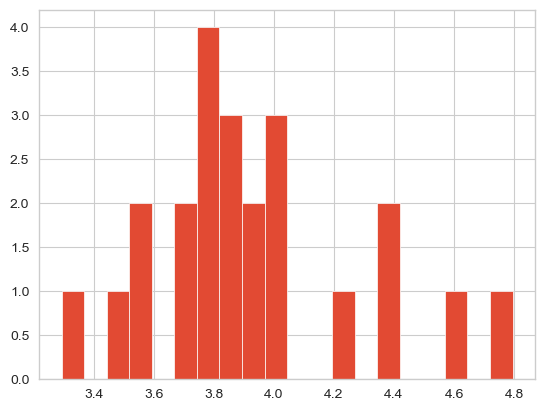

In [234]:
predictions_df_3['predicted'].hist(bins=20)

<AxesSubplot:>

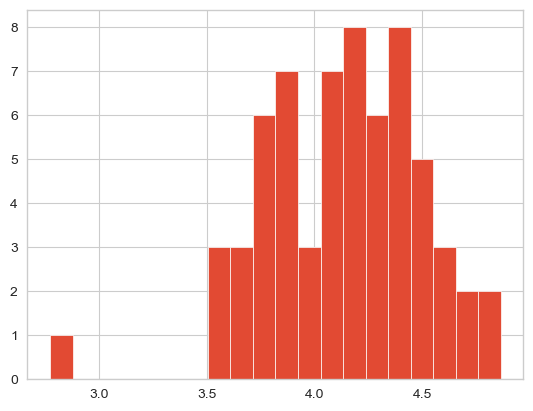

In [235]:
predictions_df_4['predicted'].hist(bins=20)

<AxesSubplot:>

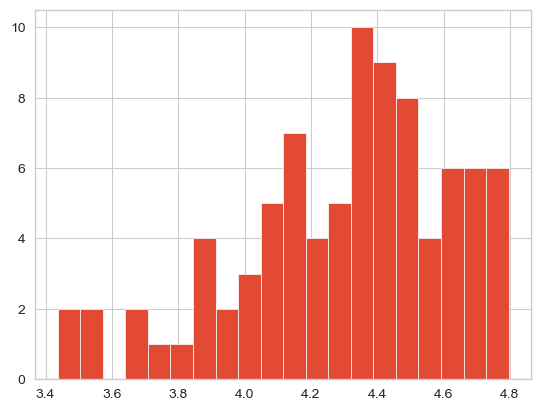

In [236]:
predictions_df_5['predicted'].hist(bins=20)

In [237]:
# Build out anti-testset in order to generate recommendations
full_trainset = data_3.build_full_trainset()
algo = SVD(n_factors=20,
             n_epochs=25,
             lr_all=0.006,
             reg_all=0.08)
algo.fit(full_trainset)
full_testset = full_trainset.build_anti_testset()
full_predictions = algo.test(full_testset)
top_n = get_top_n(full_predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Po4BCvGrKtP_OfZwMUp87g ['eGi7CE2YaN6YMiGyXNi8XQ', 'RIQ5ALCz1-oi98ViCO7kgQ', 'a_oRfgkNFnulTada--P_Tg', 'CJoO4HYD0tZRXlZqA04wmw', 'RHdEScVIAQ7xzFFMiQEnAQ', 'o3woQWQ-0HxFftItIEeNdw', 'AL89lQXFfE0HpbTvpxuSkA', 'XyGRDrgCK0z4CiA6nhwEaw', 'xwKYBPO0ByGlkvNcr8FdqQ', 'jZ1rUspubgkuZjwKJMhEEw']
lYu0e98ZSNeXIjcLpkjhhA ['eGi7CE2YaN6YMiGyXNi8XQ', 'RIQ5ALCz1-oi98ViCO7kgQ', 'CJoO4HYD0tZRXlZqA04wmw', 'p7tSGmWpFV246aYhwODgBg', 'o3woQWQ-0HxFftItIEeNdw', 'XyGRDrgCK0z4CiA6nhwEaw', 'AL89lQXFfE0HpbTvpxuSkA', 'dlOTtFJbcyN1m5PR2IDxOg', 'xwKYBPO0ByGlkvNcr8FdqQ', 'jZ1rUspubgkuZjwKJMhEEw']
mNMkTmGkVeA-Hq2FwAO_LQ ['eGi7CE2YaN6YMiGyXNi8XQ', 'RIQ5ALCz1-oi98ViCO7kgQ', 'a_oRfgkNFnulTada--P_Tg', 'RHdEScVIAQ7xzFFMiQEnAQ', 'CJoO4HYD0tZRXlZqA04wmw', 'p7tSGmWpFV246aYhwODgBg', 'AL89lQXFfE0HpbTvpxuSkA', 'o3woQWQ-0HxFftItIEeNdw', 'XyGRDrgCK0z4CiA6nhwEaw', 'dlOTtFJbcyN1m5PR2IDxOg']
Y7ns5C9DSYNBJDI0GVv3aw ['eGi7CE2YaN6YMiGyXNi8XQ', 'RIQ5ALCz1-oi98ViCO7kgQ', 'a_oRfgkNFnulTada--P_Tg', 'CJoO4HYD0tZRXlZqA04wmw', 'XyGRDrgCK0z4CiA6nhw

In [238]:
top_n['Po4BCvGrKtP_OfZwMUp87g']

[('eGi7CE2YaN6YMiGyXNi8XQ', 4.900631757237933),
 ('RIQ5ALCz1-oi98ViCO7kgQ', 4.7282533340360295),
 ('a_oRfgkNFnulTada--P_Tg', 4.643903005583707),
 ('CJoO4HYD0tZRXlZqA04wmw', 4.6317326163903445),
 ('RHdEScVIAQ7xzFFMiQEnAQ', 4.58858745987313),
 ('o3woQWQ-0HxFftItIEeNdw', 4.521214421856598),
 ('AL89lQXFfE0HpbTvpxuSkA', 4.508791327999613),
 ('XyGRDrgCK0z4CiA6nhwEaw', 4.496283870326185),
 ('xwKYBPO0ByGlkvNcr8FdqQ', 4.488894551250106),
 ('jZ1rUspubgkuZjwKJMhEEw', 4.446985635597712)]

In [239]:
utility_3[utility_3['user_id'] == '4Uh27DgGzsp6PqrH913giQ']

,user_id,business_id,review_stars


In [240]:
def find_and_compare(user_id, top_n):
    '''
    Returns the raw user id associated with a given Surprise inner id

    Arguments:
    user_id (string): user_id string
    top_n (dict): top_n dictionary generated from get_top_n

    Returns:
    reviewed_businesses_df (dataframe): dataframe of businesses reviewed by
    the given user
    recommended_df (dataframe): dataframe of recommended restaurants
    '''
    reviewed_df = utility_3[utility_3['user_id'] == user_id]
    merged_reviewed_df = reviewed_df.merge(right=business_df,
                                           how='left',
                                           left_on='business_id',
                                           right_on='business_id')
    reviewed_businesses_df = merged_reviewed_df[['business_name',
                                                 'review_stars',
                                                 'categories']]

    top_n_df = pd.DataFrame(columns=['business_id', 'predicted'])
    i = 0
    for business, predicted in top_n[user_id]:
        top_n_df.loc[i] = [business, predicted]
        i += 1
    top_n_businesses_df = top_n_df.merge(right=business_df,
                                         how='left',
                                         left_on='business_id',
                                         right_on='business_id')
    recommended_df = top_n_businesses_df[['business_name',
                                          'predicted',
                                          'categories']]

    return reviewed_businesses_df, recommended_df

In [241]:
# Average number of reviews left by a user
utility_3['user_id'].value_counts().mean()

4.004201680672269

In [242]:
# Compare/contrast recommended restaurants and actual reviews provided
actual_df, recommended_df = find_and_compare('Po4BCvGrKtP_OfZwMUp87g', top_n)

In [243]:
actual_df

,business_name,review_stars,categories
0,Sushi Nara,4,"Sushi Bars, Japanese, Restaurants"
1,O Sushi Restaurant,5,"Sushi Bars, Restaurants, Japanese"
2,Prep & Pastry on Grant,5,"American (New), Restaurants, Breakfast & Brunch"


In [244]:
recommended_df

,business_name,predicted,categories
0,Spice Garden Indian Cuisine,4.900632,"Restaurants, Indian, Vegetarian"
1,La Baguette Parisienne,4.728253,"Bakeries, Food, Restaurants"
2,Sonoran Brunch Company,4.643903,"Restaurants, Mexican, Breakfast & Brunch"
3,Crave Coffee Bar,4.631733,"Food, Coffee & Tea, Restaurants"
4,The Quesadillas,4.588587,"Tacos, Restaurants, Mexican"
5,El Rustico,4.521214,"Tacos, Mexican, Restaurants"
6,Bob's Steak & Chop House,4.508791,"Restaurants, Seafood, Steakhouses"
7,Persian Room Fine Dining,4.496284,"Restaurants, Persian/Iranian, Mediterranean"
8,Le Rendez-vous,4.488895,"Restaurants, French, Tapas/Small Plates"
9,MOD Pizza,4.446986,"Fast Food, Restaurants, Pizza"


In [245]:
def get_user_totals(uid):
    '''
    Returns the number of items rated by given user
    
    Arguments: 
    uid (string): the id of the user
    
    Returns: 
    (int): the number of items rated by the user
    '''
    try:
        return len(trainset_3.ur[trainset_3.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_item_totals(iid):
    '''
    Returns the number of users that have rated a given item
    
    Arguments:
    iid (string): the raw id of the item
      
    Returns:
    (int): the number of users that have rated the item.
    '''
    try: 
        return len(trainset_3.ir[trainset_3.to_inner_iid(iid)])
    except ValueError:
        return 0

In [246]:
# Generate the best/worst predictions by absolute error
predictions_df['user_totals'] = predictions_df['uid'].apply(get_user_totals)
predictions_df['item_totals'] = predictions_df['iid'].apply(get_item_totals)
predictions_df['err'] = abs(predictions_df['predicted'] -
                            predictions_df['true'])
best_predictions = predictions_df.sort_values(by='err')[:50]
worst_predictions = predictions_df.sort_values(by='err')[-50:]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5')]

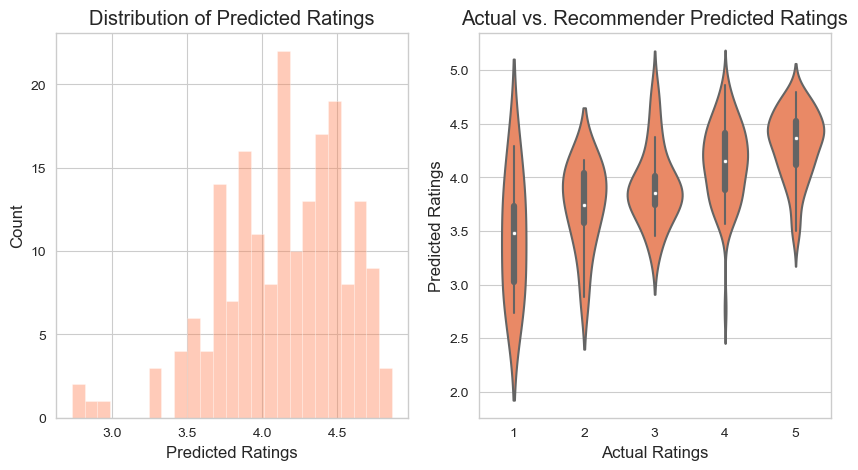

In [247]:
# Plot prediction distributions via histogram & violin plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.distplot(predictions_df['predicted'], bins=25, norm_hist=False,
             color='coral', ax=axs[0], kde=False)
axs[0].set_title('Distribution of Predicted Ratings')
axs[0].set_xlabel('Predicted Ratings')
axs[0].set_ylabel('Count')

pred_data = ([predictions_df['predicted'][predictions_df['true'] == rating]
              .values for rating in range(1, 6)])
sns.violinplot(data=pred_data, ax=axs[1], color='coral')
axs[1].set_title('Actual vs. Recommender Predicted Ratings')
axs[1].set_xlabel('Actual Ratings')
axs[1].set_ylabel('Predicted Ratings')
axs[1].set_xticklabels(np.arange(1,6))


In [248]:
best_predictions

,uid,iid,true,predicted,user_totals,item_totals,err
189,G-DzOxoh7tniSa5K7apy-g,5CX7rtnwYnmqFCihOyWivg,4.0,3.976888,1,41,0.023112
45,ig0NAzZ9J_6cF0gChtvJuA,5Ce3lZksYVkCbrihqylVHQ,4.0,4.025017,1,26,0.025017
83,glv7NwPTYMEuq90lQhhnlw,l8yqThofpWGUs6lxOeIdOA,4.0,4.058061,7,46,0.058061
73,OKrzRxFVM0TPI8afVB8LiA,IJ5N0TNgDDFP0UauRmepDg,4.0,3.931275,1,30,0.068725
150,aakUfHsqjH8ZNHgCihwOFA,jZ1rUspubgkuZjwKJMhEEw,4.0,4.080251,2,38,0.080251
136,R7NM7vIyUfSTXvMsw7jNTA,A93_XS0xZu1OtfQPTIJeqw,4.0,3.913585,2,8,0.086415
177,1viszljzsa8W7VnYPuWosw,dlOTtFJbcyN1m5PR2IDxOg,4.0,4.097983,10,21,0.097983
17,9Y1YkloHk2MAE3hkwYdFKA,5CX7rtnwYnmqFCihOyWivg,4.0,3.891404,13,41,0.108596
153,xdEEatG19QPNdRw_ovDeFg,Wp9D-r8Ap1Fv0IIM0zGfoQ,4.0,3.887972,2,26,0.112028
162,ow1YVonkr8G-8kFUKo-bJg,CJoO4HYD0tZRXlZqA04wmw,4.0,4.118150,2,41,0.118150


In [249]:
worst_predictions

,uid,iid,true,predicted,user_totals,item_totals,err
48,srx_nUpba8cwwzdcZunaCA,Wp9D-r8Ap1Fv0IIM0zGfoQ,3.0,3.888545,2,26,0.888545
109,Fz8uo7UVvueCbx48qAI5fw,5Ce3lZksYVkCbrihqylVHQ,5.0,4.102507,1,26,0.897493
64,aHiQYaTXrmQTeG6106l5wg,nEaTbGFlU7d9eLU2kl6KBw,3.0,3.898328,1,40,0.898328
171,IJN-45eOGi1gUihoYAc5jQ,IJ5N0TNgDDFP0UauRmepDg,5.0,4.093141,2,30,0.906859
181,PeYXmSr3Yx-xQ3ohKJQo5A,vtbAuFCR8ugUaajtF_wDEQ,5.0,4.089215,1,14,0.910785
170,IPcgVWB-KXlb5bqt8fqE0Q,RHdEScVIAQ7xzFFMiQEnAQ,3.0,3.931334,3,49,0.931334
164,W67nXodRWTIa-d1NJlncvA,KZA_HEOsBXf8dtrk9rqNJA,5.0,4.067910,2,71,0.932090
110,fdFgZQQYQJeEAshH4lxSfQ,nEaTbGFlU7d9eLU2kl6KBw,5.0,4.051320,4,40,0.948680
18,L2U4I05dvNsgCpm0NIxkJA,KZA_HEOsBXf8dtrk9rqNJA,3.0,3.986241,6,71,0.986241
20,gUwNvcxv8POu1YA14h7vnQ,nEaTbGFlU7d9eLU2kl6KBw,5.0,4.008092,2,40,0.991908


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Counts (Log)')

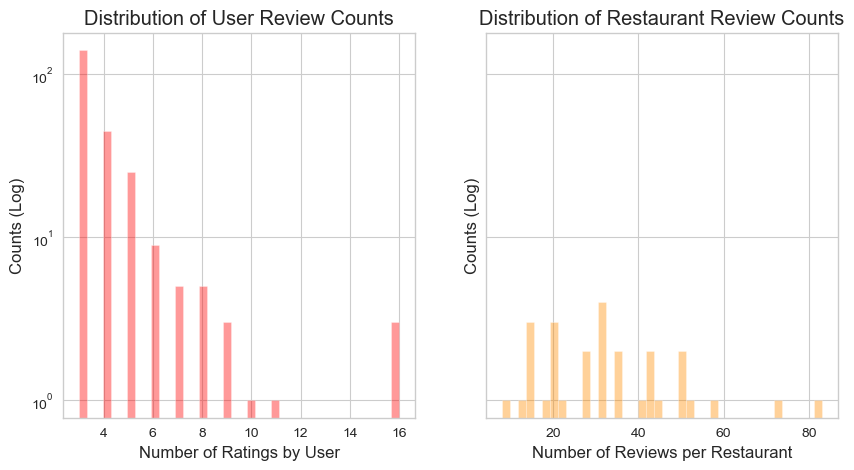

In [250]:
# Plots of user/restaurant review counts
fig, axs = plt.subplots(1,2,figsize=(10,5), sharey=True)

sns.distplot(utility_user_ratings, kde=False, color='red', norm_hist=False,
             ax=axs[0], bins=40)
axs[0].set_title('Distribution of User Review Counts')
axs[0].set_yscale('log')
axs[0].set_xlabel('Number of Ratings by User')
axs[0].set_ylabel('Counts (Log)')

sns.distplot(utility_rest_ratings, color='darkorange', norm_hist=False,
             kde=False, ax=axs[1], bins=40)
axs[1].set_yscale('log')
axs[1].set_title('Distribution of Restaurant Review Counts')
axs[1].set_xlabel('Number of Reviews per Restaurant')
axs[1].set_ylabel('Counts (Log)')



Text(0, 0.5, 'Counts')

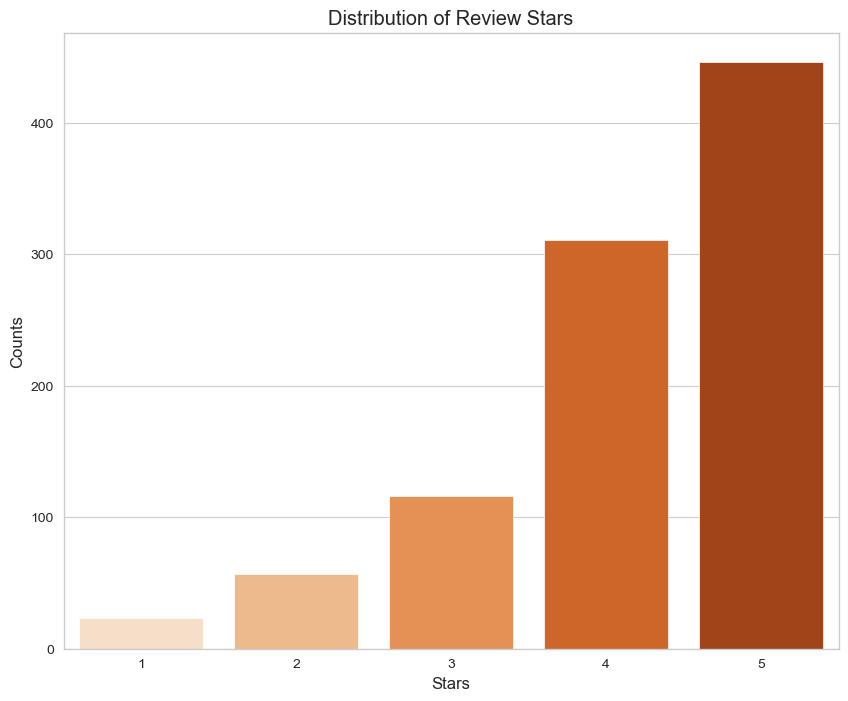

In [251]:
# Bar plot of counts of review stars
fig, ax = plt.subplots(figsize=(10, 8))
utility_review_stars = (utility_3['review_stars']
                        .value_counts(ascending=True))
sns.barplot(x='index', y='review_stars',
            data=utility_review_stars.reset_index(), palette='Oranges',
            ax=ax)
ax.set_title('Distribution of Review Stars')
ax.set_xlabel('Stars')
ax.set_ylabel('Counts')



In [252]:
# The following cells evaluate predictions on a user by user basis
# Looking to see how error changes depending on presence in testset
predictions_df[predictions_df['uid'] == 'Po4BCvGrKtP_OfZwMUp87g']

,uid,iid,true,predicted,user_totals,item_totals,err
167,Po4BCvGrKtP_OfZwMUp87g,KZA_HEOsBXf8dtrk9rqNJA,5.0,4.204946,2,71,0.795054


In [253]:
calc_rmse = predictions_df[predictions_df['uid'] == 'Po4BCvGrKtP_OfZwMUp87g']
predictions_df[predictions_df['uid'] == 'Po4BCvGrKtP_OfZwMUp87g']

,uid,iid,true,predicted,user_totals,item_totals,err
167,Po4BCvGrKtP_OfZwMUp87g,KZA_HEOsBXf8dtrk9rqNJA,5.0,4.204946,2,71,0.795054


In [254]:
predictions_df[predictions_df['uid'] == 'Po4BCvGrKtP_OfZwMUp87g'].shape

(1, 7)

In [255]:
predictions_df[predictions_df['uid'] == 'Po4BCvGrKtP_OfZwMUp87g']['err'].mean()

0.795054024085136

In [256]:
((calc_rmse.true - calc_rmse.predicted) ** 2).mean() ** .5

0.795054024085136

In [257]:
user_df[user_df['user_id'] == 'Po4BCvGrKtP_OfZwMUp87g']

,user_id,user_name,review_count,yelping_since,average_stars
1238,Po4BCvGrKtP_OfZwMUp87g,Preston,40,2015-12-07 02:28:47,2.6


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


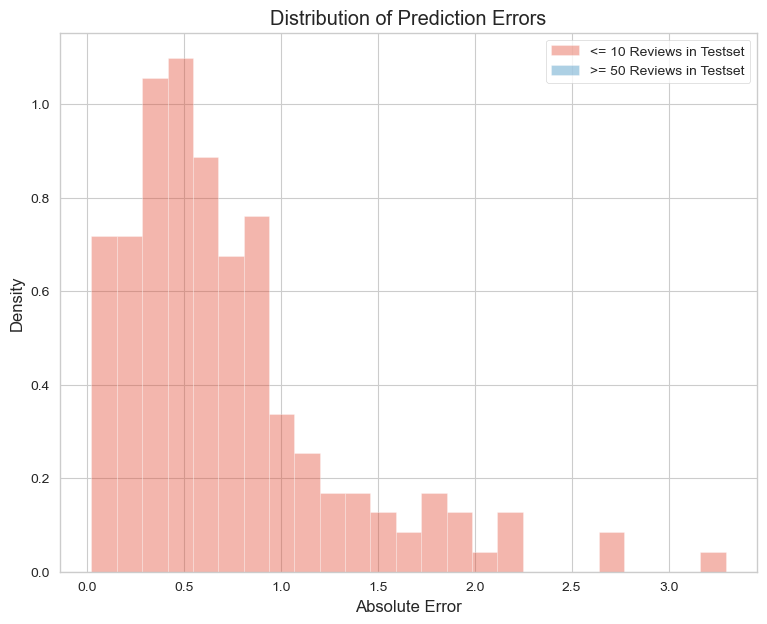

In [258]:
fig, ax = plt.subplots(figsize=(9,7))
user_under = predictions_df[predictions_df['user_totals'] <= 10]
user_over = predictions_df[predictions_df['user_totals'] >= 50]
sns.distplot(user_under['err'], label='<= 10 Reviews in Testset',
             bins=25, ax=ax, norm_hist=True, kde=False)
sns.distplot(user_over['err'], label='>= 50 Reviews in Testset',
             bins=25, ax=ax, norm_hist=True, kde=False)
ax.set_title('Distribution of Prediction Errors')
ax.set_xlabel('Absolute Error')
ax.set_ylabel('Density')
ax.legend()


(0.0, 1.03)

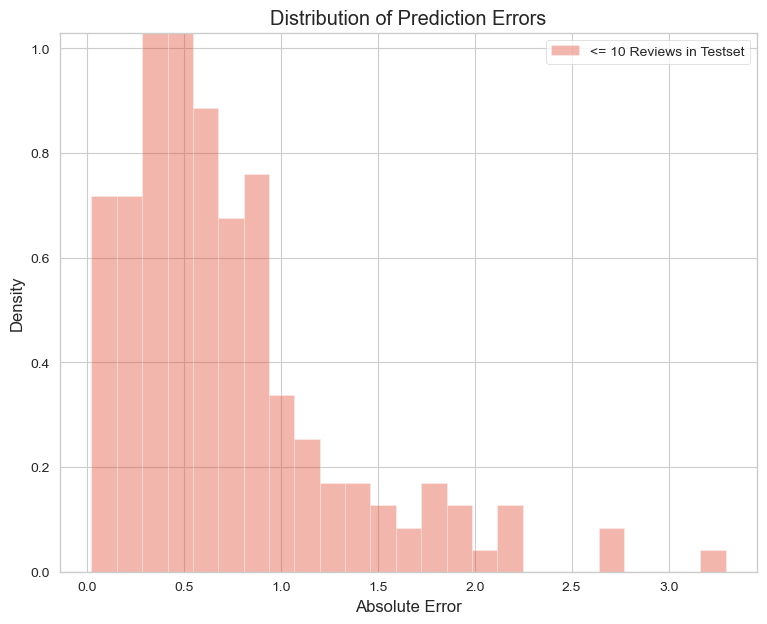

In [259]:
fig, ax = plt.subplots(figsize=(9,7))
sns.distplot(user_under['err'], label='<= 10 Reviews in Testset',
             bins=25, ax=ax, norm_hist=True, kde=False)
ax.set_title('Distribution of Prediction Errors')
ax.set_xlabel('Absolute Error')
ax.set_ylabel('Density')
ax.legend()
ax.set_ylim(0, 1.03)